<img src="https://centrofnv.cl/wp-content/uploads/2015/07/banner.jpg" align="left" style="height:320px">

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>1 |</b> Business Objective</p></div>
In this notebook, I will analyze a health insurance company's data to predict future insurance claim amounts and identify factors that lead to higher healthcare costs. The [insurance dataset](https://www.kaggle.com/mirichoi0218/insurance) consists of 1,338 policyholders with 7 attributes that describe their health and demographic information, including their age, gender, BMI, and smoking status. The variable we would like to predict is the total claim amount, `charges`, that were billed to the insurance company. To provide a more targeted cost prediction, I will build a model for each of the four regions where the company's policyholders reside in: the Southwest, Southeast, Northwest, and Northeast regions.

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>2 |</b> Data Overview</p></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load data
ins = pd.read_csv("/kaggle/input/insurance/insurance.csv")
print("There are {:,} observations and {} columns in the data set.".format(ins.shape[0], ins.shape[1]))
print("There are {} missing values in the data.".format(ins.isna().sum().sum()))
ins['sex'] = ins['sex'].str.capitalize()
ins['smoker'] = ins['smoker'].apply(lambda x: 'Smoker' if x=='yes' else 'Non-Smoker')
ins['region'] = ins['region'].str.capitalize()

There are 1,338 observations and 7 columns in the data set.
There are 0 missing values in the data.


## <b><span style='color:#5477A5'>2.1</span> | Summary Statistics of Numeric Columns</b>

In [2]:
ins.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## <b><span style='color:#5775A4'>2.2</span> | Summary Statistics of Categorical Columns</b>

In [3]:
ins.select_dtypes(include=['object']).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,Male,Non-Smoker,Southeast
freq,676,1064,364


In [4]:
cat=ins.select_dtypes(include=['object']).columns.tolist()
for i in cat:
    obs=ins[i].value_counts()
    avg_claim=ins.groupby(i)["charges"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs, "Average Claim Amount":avg_claim.map('${:,.2f}'.format)})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders,Average Claim Amount
Male,676,"$13,956.75"
Female,662,"$12,569.58"


,Number of Policyholders,Average Claim Amount
Non-Smoker,1064,"$8,434.27"
Smoker,274,"$32,050.23"


,Number of Policyholders,Average Claim Amount
Southeast,364,"$14,735.41"
Northwest,325,"$12,417.58"
Southwest,325,"$12,346.94"
Northeast,324,"$13,406.38"


# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>3 |</b> Exploratory Data Analysis</p></div>

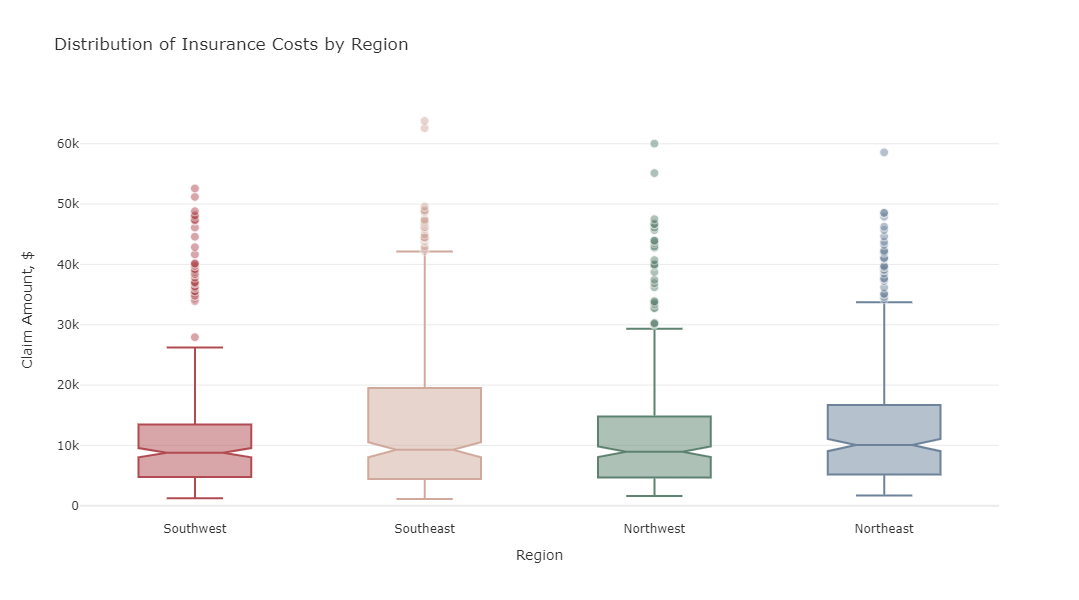

In [5]:
init_notebook_mode(connected=True)
px.defaults.template = "plotly_white"
plot_df=ins.copy()
fig = px.box(plot_df, x="region", y="charges", color="region", 
             notched=True, points="outliers", height=600,
             title="Distribution of Insurance Costs by Region",
             color_discrete_sequence=['#B14B51', '#D0A99C', '#5D8370', '#6C839B'])
fig.update_traces(marker=dict(size=9, opacity=0.5, line=dict(width=1,color="#F7F7F7")), showlegend=False)
fig.update_layout(font_color="#303030", xaxis_title='Region', yaxis_title='Claim Amount, $',
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'))
fig.show()

For each region, the boxplots show insurance charges are positively skewed with several large outliers. Insurance charges are more variable in the Southeast region, which contains the highest claim in the data set at over \\$63,000 as well as the lowest claim at \$1,121. The Northeast region has the highest median cost overall, although since the notches in the boxplots overlap, the median claim amounts are likely not significantly different.

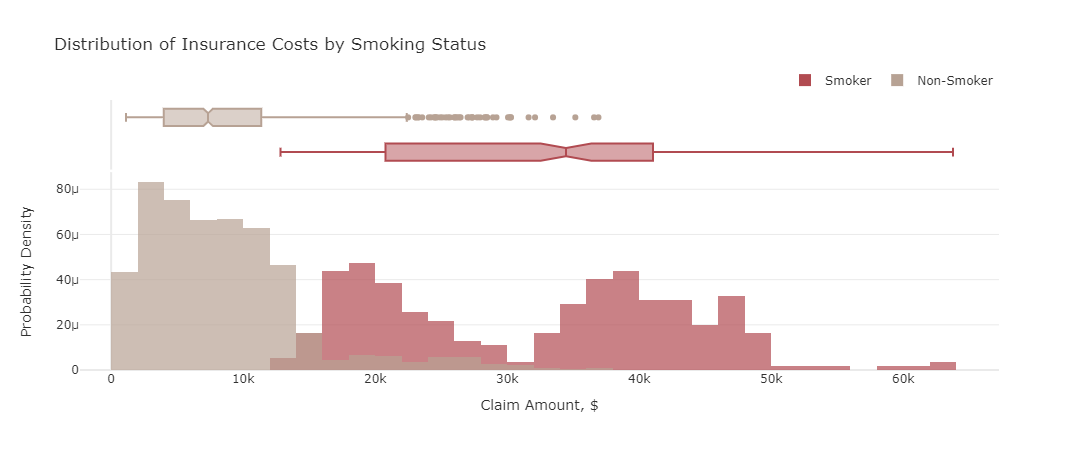

In [6]:
fig=px.histogram(ins, x='charges', color='smoker', opacity=0.7, barmode='overlay',
                 histnorm='probability density', marginal='box', 
                 title="Distribution of Insurance Costs by Smoking Status",
                 color_discrete_sequence=['#B14B51','#B7A294']) 
fig.update_layout(font_color="#303030", xaxis_title='Claim Amount, $',
                  yaxis=dict(title='Probability Density', gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.update_xaxes(showgrid=False, zerolinecolor='#EAEAEA')
fig.show()

The median claim amount of non-smokers is around \\$7,300, which is quite lower than the median claim of smokers at over \\$34,000. The distribution of insurance costs between the groups is also notably different. For non-smokers, the distribution is skewed to the right, while claim amounts for smokers have more variability with a wider spread in the boxplot and a bimodal distribution with peaks near \\$20,000 and \$40,000.

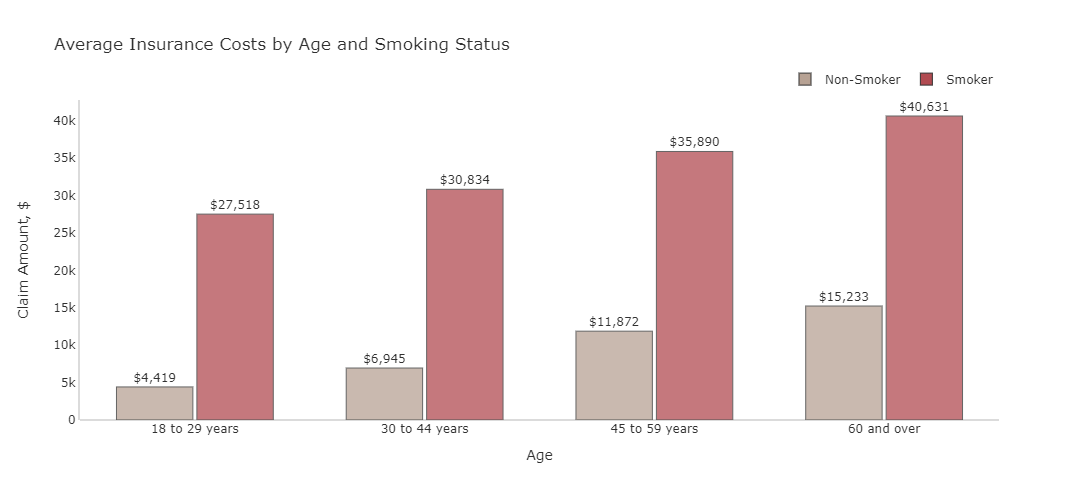

In [7]:
plot_df = ins.copy()
plot_df["Age_Group"]=['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else 
                      '45 to 59 years' if (i>=45)&(i<60) else '60 and over' for i in ins['age']]
plot_df = plot_df.groupby(['Age_Group','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index().sort_values('smoker', ascending=True)
fig = px.bar(plot_df, x='Age_Group', y='charges', color='smoker', height=500, text='charges', 
             opacity=0.75, barmode='group', color_discrete_sequence=['#B7A294','#B14B51'],
             title="Average Insurance Costs by Age and Smoking Status")
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.update_layout(font_color="#303030",bargroupgap=0.05, bargap=0.3, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""),
                  xaxis=dict(title='Age',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $', showgrid=False,zerolinecolor='#DBDBDB',
                             showline=True, linecolor='#DBDBDB', linewidth=2))
fig.show()

Among each age group, insurance charges are significantly higher on average in smokers than non-smokers. We also see higher claim amounts as age increases with the most expensive claims in the 60 and over age group.

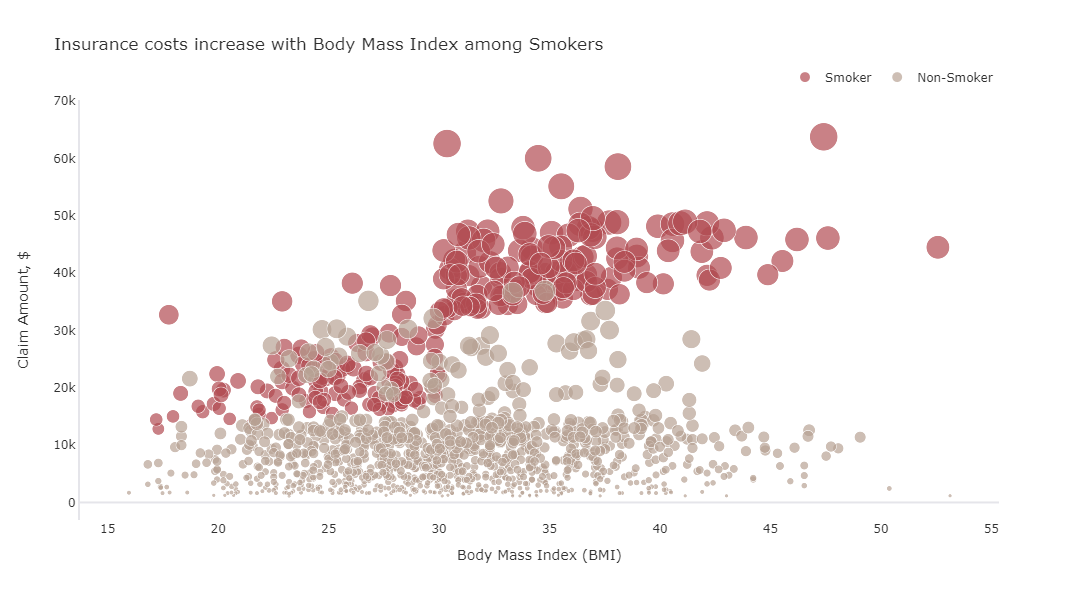

In [8]:
fig = px.scatter(ins, x='bmi', y='charges', color='smoker', size='charges',
                 title="Insurance costs increase with Body Mass Index among Smokers",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)
fig.update_layout(legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  font_color="#303030", xaxis=dict(title='Body Mass Index (BMI)',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $',showgrid=False, zerolinecolor='#E5E5EA',
                             showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show()

In addition to age, claim amounts are positively correlated to body mass index. Among smokers, insurance charges tend to increase with BMI.

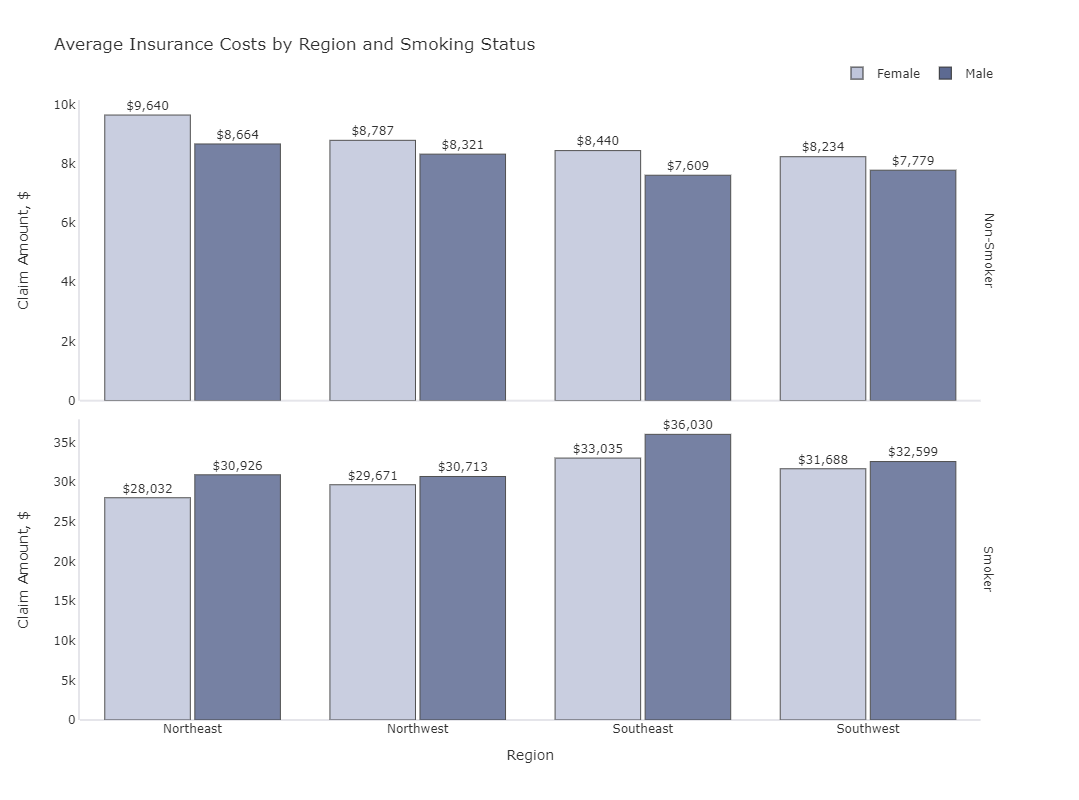

In [9]:
plot_df = ins.groupby(['region','sex','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index()
fig = px.bar(plot_df, x='region', y='charges', color='sex', height=800,
             title="Average Insurance Costs by Region and Smoking Status",
             color_discrete_map={'Female': '#BFC5DA','Male': '#5D6A92'}, 
             facet_row='smoker', text='charges', opacity=0.85, barmode='group')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.layout.yaxis2.update(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title="Region", row=1)
fig.update_yaxes(title="Claim Amount, $",  gridcolor='#E3E3E3', zeroline=True, zerolinewidth=2, 
                 showgrid=False, zerolinecolor='#E5E5EA',
                 showline=True, linecolor='#E5E5EA', linewidth=2)
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white",
                  bargroupgap=0.05, bargap=0.2,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.show()

Non-smokers tend to have smaller insurance claims on average than smokers at a little under \\$10,000 within each region, while smokers' claims range from an average of \$28,000 to over \\$36,000. The graph also shows that women who are non-smokers have slightly higher average costs than men, while among smokers, men have slightly higher charges on average than women.

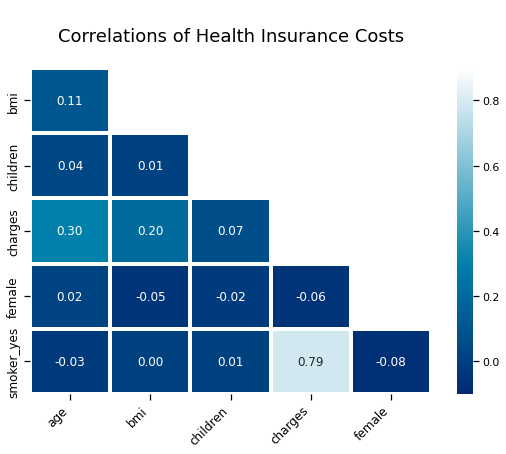

In [10]:
ins['female'] = ins['sex'].apply(lambda x: 1 if x=='Female' else 0)
ins['smoker_yes'] = ins['smoker'].apply(lambda x: 1 if x=='Smoker' else 0)
ins.drop(['sex', 'smoker'], axis=1, inplace=True)

sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(9,6))   
corr=ins.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-.1, vmax=.9, center=0, annot=True, fmt='.2f', 
               cmap='ocean', linewidths=4, annot_kws={"fontsize":12})
ax.set_title('\nCorrelations of Health Insurance Costs\n', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

The correlation matrix shows that smokers have a strong positive relationship with insurance charges at 0.79, but overall, the variables in the dataset are not too highly correlated with each other.

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>4 |</b> Methodology</p></div>
To account for the relationships that two independent variables may have on healthcare costs, like smoking status and BMI, I will add interaction terms and second-order polynomial features to the models. This will add a squared term for each variable in the model and an interaction term between each pair of features. 

There is an approximately equal number of beneficiaries in the four regions, between 324 and 364. To provide a more targeted cost prediction of future claims, I will fit separate models for each region. The models will first filter the data by region and then create individual training and test sets. I'll use several regression models to predict future insurance costs, including Linear Regression, K-Nearest Neighbors, Support Vector Machines, and Gradient Boosting. Hyperparameter tuning will be performed using cross-validation and then the models will be evaluated on the held-out test set.

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>5 |</b> Linear Regression with PCA Dimensionality Reduction</p></div>
With the addition of polynomial features, the number of variables in the dataset increases from 5 to 20. Due to the effects of multicollinearity, I will use Principal Component Analysis (PCA) to reduce the correlation between the features in the linear regression models. Principal Component Analysis is a technique that reduces the dimensionality of a data set by transforming variables that are potentially correlated into linearly uncorrelated principal components.


Region: Southwest

Number of Principal Components = 7
Train Shape:(260, 7) (260,)  Test Shape:(65, 7) (65,)
Test Error (RMSE) = 5,349.04
R-Squared = 79.15%, Adjusted R-Squared = 76.59%
__________________________

Region: Southeast

Number of Principal Components = 7
Train Shape:(291, 7) (291,)  Test Shape:(73, 7) (73,)
Test Error (RMSE) = 4,699.59
R-Squared = 90.32%, Adjusted R-Squared = 89.27%
__________________________

Region: Northwest

Number of Principal Components = 6
Train Shape:(260, 6) (260,)  Test Shape:(65, 6) (65,)
Test Error (RMSE) = 6,305.7
R-Squared = 74.43%, Adjusted R-Squared = 71.79%
__________________________

Region: Northeast

Number of Principal Components = 7
Train Shape:(259, 7) (259,)  Test Shape:(65, 7) (65,)
Test Error (RMSE) = 6,231.75
R-Squared = 63.27%, Adjusted R-Squared = 58.76%


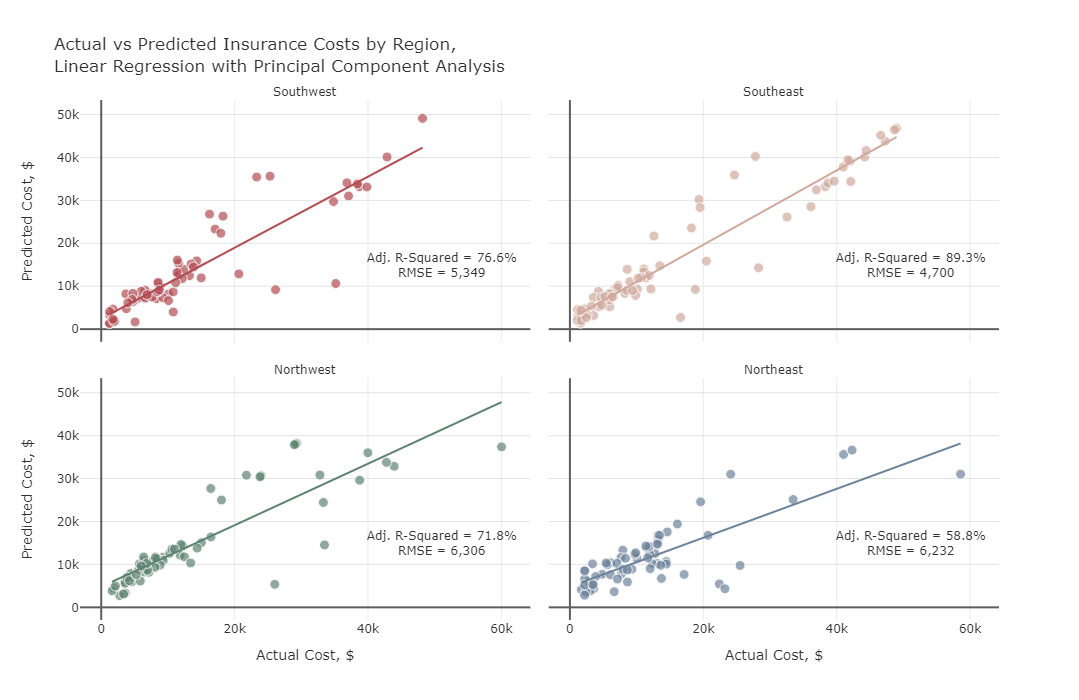

In [11]:
# Dataframe to save results
models=["Linear Regression", "KNN", "SVM", "Gradient Boosting"]
mod_res=pd.DataFrame(columns=["Average RMSE", "Avg. Adjusted R2"], index=models)
regions = ins.region.unique()
s = StandardScaler()

actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]

for i in regions:
    
    # Filter data by region
    print("\nRegion: {}\n".format(i))
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    
    # Scale features
    X_train_scaled = s.fit_transform(X_train)
    X_test_scaled = s.transform(X_test)
    
    # PCA
    pca = PCA(.95)
    X_train_pca=pca.fit_transform(X_train_scaled)
    X_test_pca=pca.transform(X_test_scaled)
    print("Number of Principal Components = {}".format(pca.n_components_))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape))
    
    # Linear Regression
    lr = LinearRegression().fit(X_train_pca, y_train)
    y_pred=lr.predict(X_test_pca)
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test_pca.shape[1]-1)
    
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)
col = ["#B14B51", '#D0A99C', '#5D8370','#6C839B']
fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="ols", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Linear Regression with Principal Component Analysis",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10, line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()

## <b><span style='color:#5477A5'>5.1</span> | Model Summary</b>

In [12]:
mod_res.iloc[0,0]=pd.Series(rmses).mean()
mod_res.iloc[0,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:1,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
Linear Regression,5646.52,0.741028


Out of the four models, linear regression performs the best predicting insurance costs in the Southeast region with an adjusted $R^2$ of 89.3% and an RMSE of about 4,700. This indicates that our model can explain about 89% of the variation in insurance costs in the Southeast region and leads to test predictions that are within approximately $4,700 of the true median claim amount.

Each model uses 7 principal components, except for the Northwest region. The Northwest model uses just 6 principal components and can explain over 70% of the variance in insurance costs, although it produces the highest test error out of all the regions.

Overall, the test error of the linear models range from a low of 4,700 in the Southeast to a high of about 6,300 in the Northwest and produce an average adjusted $R^2$ of 74.1%.

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>6 |</b> K-Nearest Neighbors</p></div>


Region: Southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,227.12
R-Squared = 80.09%, Adjusted R-Squared = 71.04%
__________________________

Region: Southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)
Test Error (RMSE) = 4,455.86
R-Squared = 91.29%, Adjusted R-Squared = 87.95%
__________________________

Region: Northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 6,179.18
R-Squared = 75.45%, Adjusted R-Squared = 64.29%
__________________________

Region: Northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,617.89
R-Squared = 70.15%, Adjusted R-Squared = 56.58%


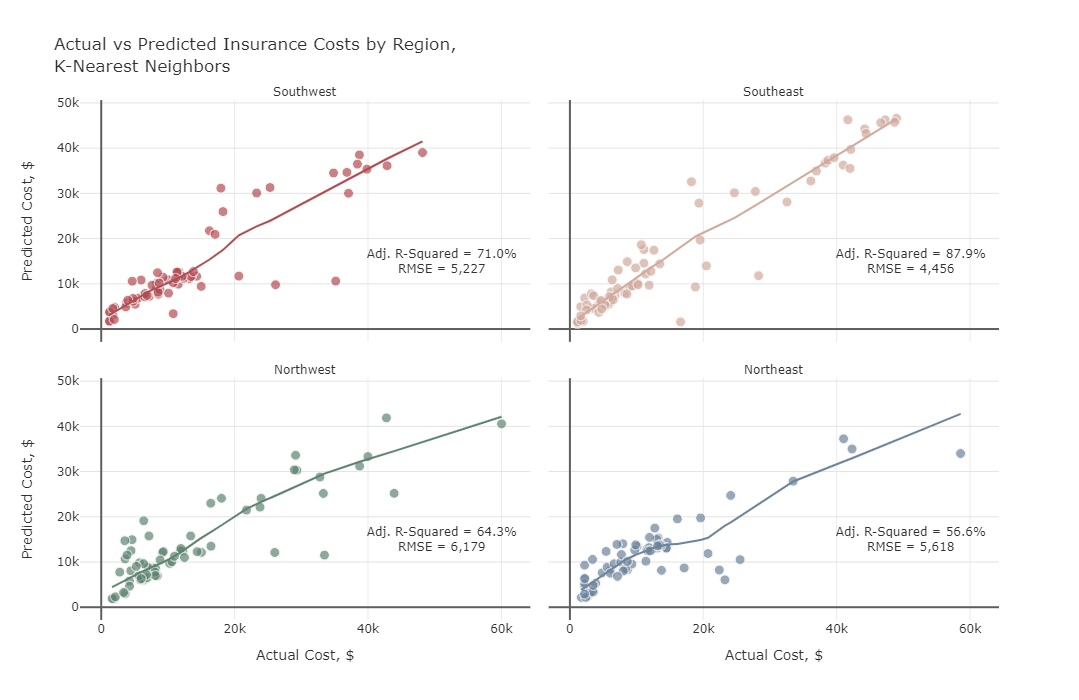

In [13]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]

for i in regions:
    
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    # KNN
    grid = {'n_neighbors': range(2, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [int(x) for x in np.linspace(10, 50, num = 5)],
            'p': [1, 2]}
    knn=KNeighborsRegressor()
    knn_cv=RandomizedSearchCV(estimator=knn, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    knn_cv.fit(X_train, y_train)
    y_pred=knn_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

    
# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>K-Nearest Neighbors",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()

## <b><span style='color:#5477A5'>6.1</span> | Model Summary</b>

In [14]:
mod_res.iloc[1,0]=pd.Series(rmses).mean()
mod_res.iloc[1,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:2,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
KNN,5370.0125,0.699643
Linear Regression,5646.52,0.741028


The KNN models produce a better test error overall than linear regression, but explains less of the observed variation in insurance costs across all four regions.

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>7 |</b> Support Vector Regression</p></div>


Region: Southwest

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 5,119.96
R-Squared = 80.90%, Adjusted R-Squared = 72.21%
__________________________

Region: Southeast

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 4,276.06
R-Squared = 91.98%, Adjusted R-Squared = 88.90%
__________________________

Region: Northwest

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 6,092.5
R-Squared = 76.13%, Adjusted R-Squared = 65.28%
__________________________

Region: Northeast

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 4,688.98
R-Squared = 79.21%, Adjusted R-Squared = 69.75%


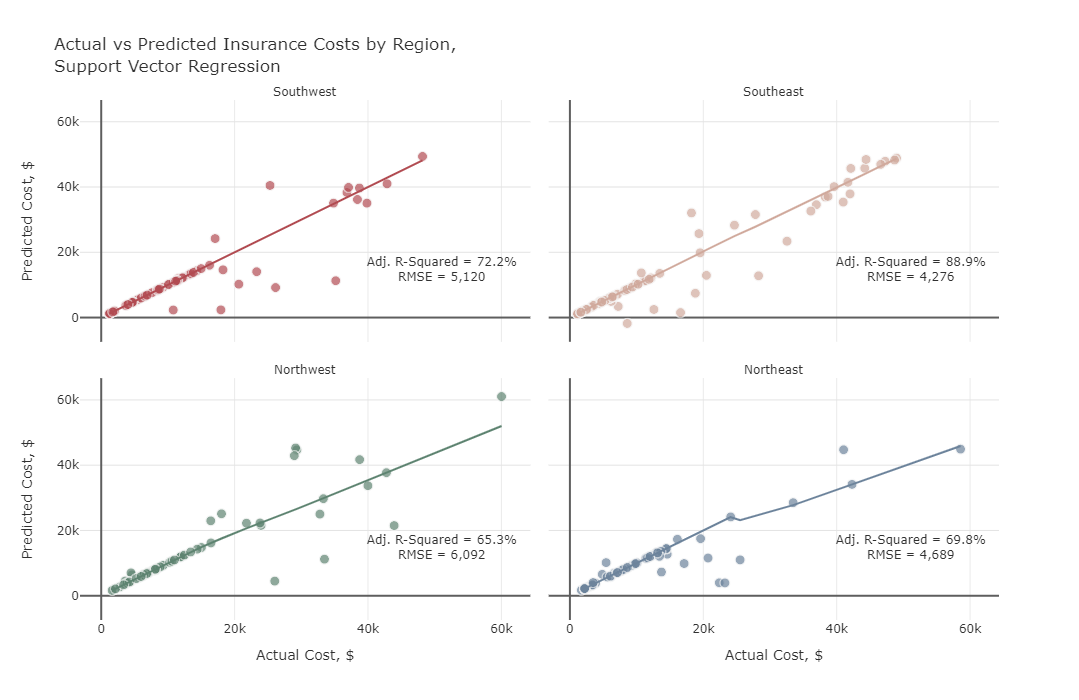

In [15]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
feat_importance=pd.DataFrame()

for i in regions:
    
    print("\nRegion: {}\n".format(i))
    
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    # Tuning SVM
    grid = {'kernel':['linear','rbf','poly','sigmoid'],
            'C': np.logspace(-3, 3, 10),
            'gamma':np.logspace(-3, 3, 10)}
    svm = SVR()
    svm_cv=RandomizedSearchCV(estimator=svm, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=10, cv=3, random_state=21, n_jobs=-1)
    svm_cv.fit(X_train, y_train)
    print("Best SVM Parameters:\n",svm_cv.best_params_)
    y_pred=svm_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("\nTest Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

    
# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Support Vector Regression",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()

## <b><span style='color:#5477A5'>7.1</span> | Model Summary</b>

In [16]:
mod_res.iloc[2,0]=pd.Series(rmses).mean()
mod_res.iloc[2,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:3,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
SVM,5044.375,0.740378
KNN,5370.0125,0.699643
Linear Regression,5646.52,0.741028


Support Vector Regression produces the lowest average test error out of the three models with an adjusted $R^2$ score of 74%. Using a polynomial kernel, the SVM models produce a lower test error across all four regions. The Northeast model made the biggest improvement with a nearly 1,000 decrease in RMSE from the KNN model. 

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>8 |</b> Gradient Boosting</p></div>


Region: Southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,117.69
R-Squared = 87.64%, Adjusted R-Squared = 82.03%
__________________________

Region: Southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)
Test Error (RMSE) = 3,212.02
R-Squared = 95.48%, Adjusted R-Squared = 93.74%
__________________________

Region: Northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,559.91
R-Squared = 86.63%, Adjusted R-Squared = 80.55%
__________________________

Region: Northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,275.79
R-Squared = 73.68%, Adjusted R-Squared = 61.71%


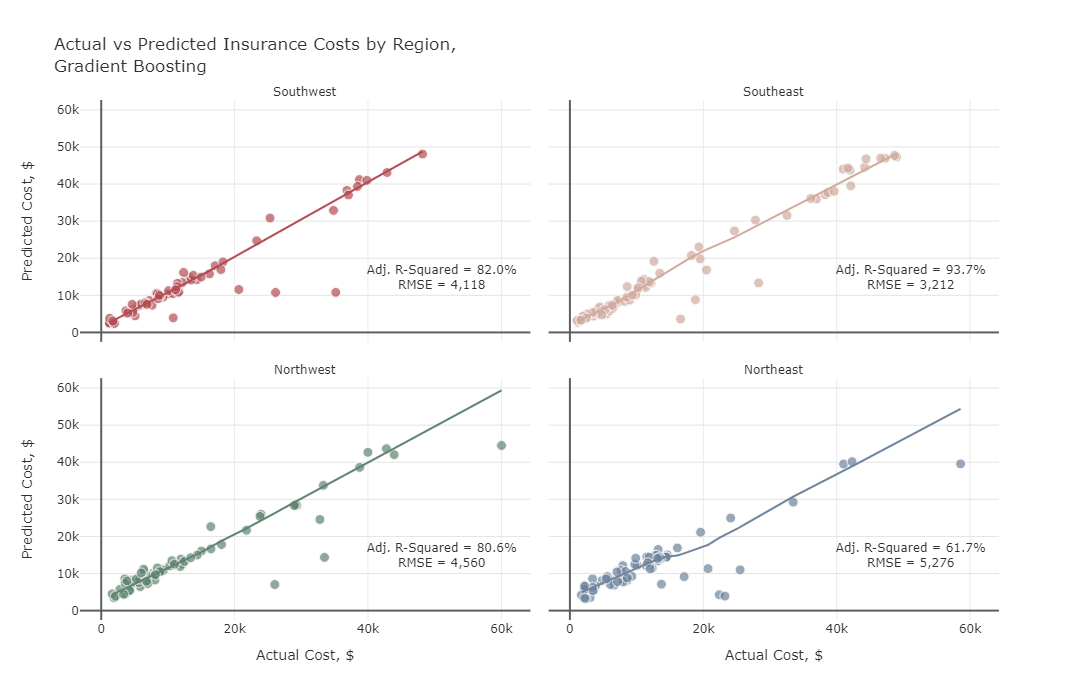

In [17]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
feat_importance=pd.DataFrame()

for i in regions:
    
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    # Tuning 
    grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5],
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
            'subsample': [0.5, 0.8, 1],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
            'max_features': [None, 'sqrt']}
    xgb=GradientBoostingRegressor(random_state=21)
    xgb_cv=RandomizedSearchCV(estimator=xgb, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    xgb_cv.fit(X_train, y_train)
    y_pred=xgb_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    # Save feature importance
    feat_importance["Importance_"+str(i)]=xgb_cv.best_estimator_.feature_importances_
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Gradient Boosting",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()

## <b><span style='color:#5477A5'>8.1</span> | Overall Model Results</b>

In [18]:
mod_res.iloc[3,0]=pd.Series(rmses).mean()
mod_res.iloc[3,1]=pd.Series(adj_r2_scores).mean()
mod_res["Average RMSE"]=mod_res["Average RMSE"].map('{:,.2f}'.format)
mod_res["Avg. Adjusted R2"]=mod_res["Avg. Adjusted R2"].mul(100).map('{:.2f}%'.format)
display(mod_res.sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
Gradient Boosting,"4,291.35",79.51%
SVM,"5,044.38",74.04%
KNN,"5,370.01",69.96%
Linear Regression,"5,646.52",74.10%


Gradient Boosting was able to reduce the test error of the models even further to 4,291 overall and increase the average adjusted $R^2$ to nearly 80%. Gradient boosting outperforms the SVR models for each region except the Northeast. Support Vector Regression provides the lowest test error in the Northeast region.

## <b><span style='color:#5477A5'>8.2</span> | Feature Importance</b>

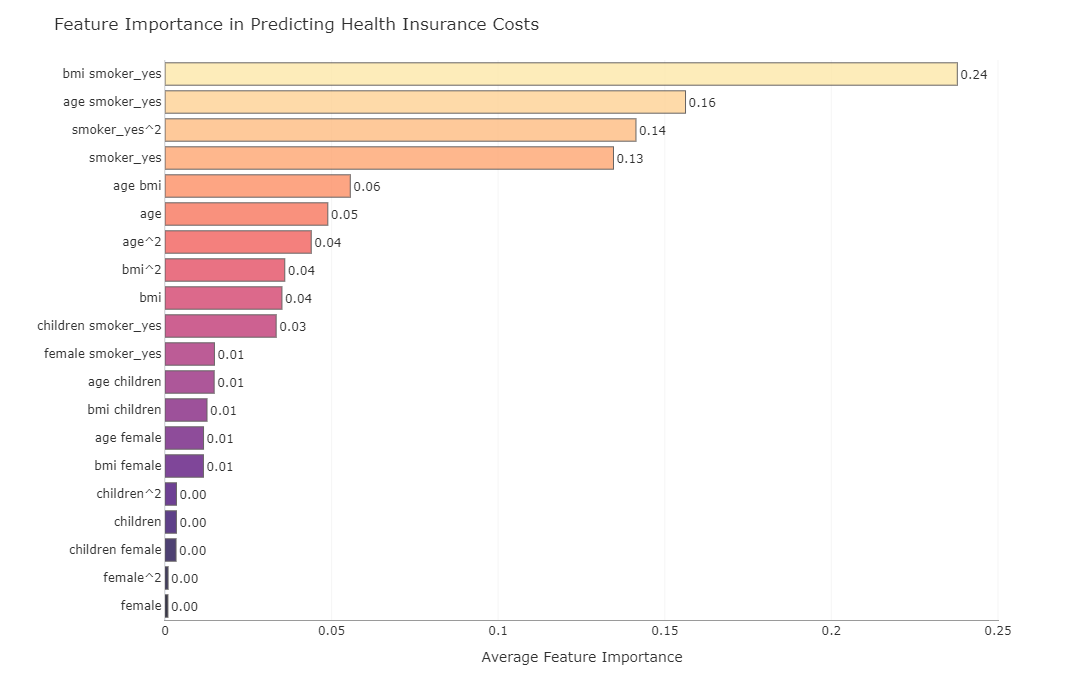

In [19]:
col=sns.color_palette("magma", 20).as_hex()[::-1]
feat_importance.set_index(X_train.columns, inplace=True)
ft=pd.DataFrame({"Average Importance":feat_importance.mean(axis=1)})
plot_df=ft.nlargest(20, columns="Average Importance").sort_values(by="Average Importance",ascending=False)
fig = px.bar(plot_df, x="Average Importance", y=plot_df.index, text="Average Importance", height=700,
             color=plot_df.index,width=700,opacity=.8,color_discrete_sequence=col)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside',
                  marker_line=dict(width=1, color='#3F3B3A'), showlegend=False, 
                  hovertemplate='Importance = <b>%{x:.2}</b>')
fig.update_layout(title_text='Feature Importance in Predicting Health Insurance Costs', 
                  coloraxis_showscale=False, yaxis_title="", font_color="#303030", yaxis_linecolor="#D8D8D8", 
                  xaxis=dict(title="Average Feature Importance", showgrid=True, showline=True, 
                             linecolor="#9A9A9A", gridcolor="#F5F5F5"))

Using the average feature importance's from the Gradient Boosting models, the interaction effect of a patient's BMI and their smoking status is the most important predictor of healthcare costs. Smoking status produces the highest average importance across the models with interactions between age and BMI among the top 5 predictors. The polynomial features of Age and BMI are also within the top 10, while gender and children are among the lowest.

# <div style="color:white;display:fill;border-radius:5px;background-color:#84A3C3;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;margin:0"><b>9 |</b> Conclusion</p></div>
In predicting insurance costs, Gradient Boosting provides the best results in the Southwest, Southeast, and Northwest regions, while the Support Vector model produces the lowest test error in the Northeast region. The models can explain over 93% of the observed variation in insurance costs in the Southeast region to almost 70% in the Northeast with the SVM model. 

The polynomial features and interaction effects that were added to the models were among some of the most important predictors of health insurance costs, particularly between a patient's smoking status and their BMI. We also saw that healthcare costs increase with age and are notably higher in smokers. Gender and number of children had the least amount of influence in the models overall.  

The Gradient Boosting model in the Northeast could potentially be improved with additional hyperparameter tuning or the company could implement a hybrid modeling approach that uses both boosted trees and support vector regression to predict insurance claims by region.

<br>

<b><p style='color:#5477A5;text-align:center'>Thank you for reading!<br>Let me know if you have any questions, and I look forward to any suggestions. 🙂</p></b>